**Point Categories**

![points](images/points.png)

In [322]:
# define a map from points to quality rating
rating_lookup = {i: 'acceptable' for i in range(80, 83)}
rating_lookup.update({i: 'good' for i in range(83, 87)})
rating_lookup.update({i: 'very good' for i in range(87, 90)})
rating_lookup.update({i: 'excellent' for i in range(90, 94)})
rating_lookup.update({i: 'superb' for i in range(94, 98)})
rating_lookup.update({i: 'classic' for i in range(98, 101)})

assert rating_lookup[90] == 'excellent'

**Load Data**

In [323]:
import pandas as pd
import numpy as np

reviews = pd.read_parquet('data/wine/wine_review.parquet.gzip', columns=['title', 'description', 'winery', 'year', 'variety', 'points', 'taster_name', 'country', 'location', 'type', 'wine_style',	'classification'])
reviews['rating'] = reviews.points.map(rating_lookup)
reviews['review_len'] = reviews.description.str.len()
print(reviews.shape)
reviews.sample(5, random_state=42)

(100538, 14)


,title,description,winery,year,variety,points,taster_name,country,location,type,wine_style,classification,rating,review_len
12616,Château Bouscaut 2006 Barrel sample (Pessac-L...,"87—89 Barrel sample. Soft fruit, followed by h...",Château Bouscaut,2006,Bordeaux-style Red Blend,88,Roger Voss,France,Bordeaux,red,full_red,Old World,very good,175
49741,Bodega Norton 2005 Privada Red (Luján de Cuyo),"Rock solid, clean and composed. For the past s...",Bodega Norton,2005,Bordeaux-style Red Blend,92,Michael Schachner,Argentina,Mendoza Province,red,full_red,New World,excellent,368
35244,Lechthaler 2014 Torre di Luna Pinot Grigio (Tr...,This uber-informal wine has faint aromas that ...,Lechthaler,2014,Pinot Grigio,83,Kerin O’Keefe,Italy,Trentino,white,light_white,Old World,good,198
52642,Sbragia 2004 Rancho Del Oso Cabernet Sauvignon...,"Those mountain tannins are here in spades, and...",Sbragia,2004,Cabernet Sauvignon,94,Unknown,US,California,red,full_red,New World,superb,343
83201,Force Majeure 2014 Estate Grown Cabernet Sauvi...,"The aromas are light initially, with notes of ...",Force Majeure,2014,Cabernet Sauvignon,91,Sean P. Sullivan,US,Washington,red,full_red,New World,excellent,308


**EDA**

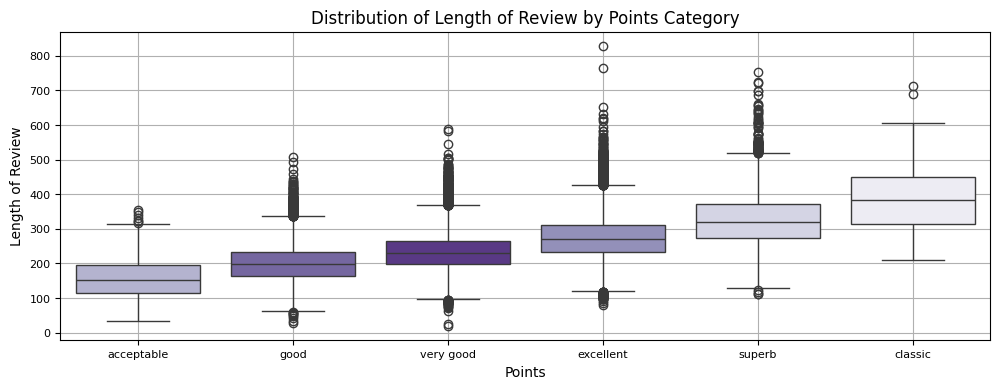

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
sns.boxplot(x = 'rating', y = 'review_len', palette = 'Purples_r', hue='rating', data = reviews, native_scale=False, legend=None, order=['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic'])
plt.title("Distribution of Length of Review by Points Category", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Length of Review",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

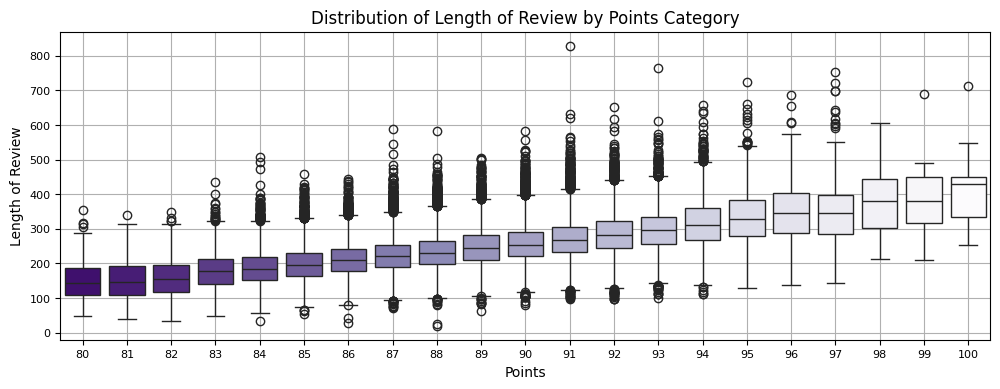

In [325]:
plt.figure(figsize=(12,4))
sns.boxplot(x = 'points', y = 'review_len', palette = 'Purples_r', hue='points', data = reviews, native_scale=False, legend=None)
plt.title("Distribution of Length of Review by Points Category", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Length of Review",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

<Axes: xlabel='rating', ylabel='count'>

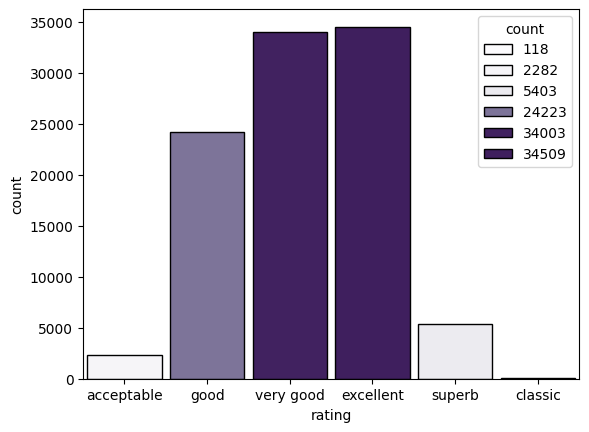

In [326]:
sns.barplot(reviews.rating.value_counts().reset_index(), x='rating', y='count', saturation=.5, gap=.1, width=1, edgecolor='k', 
            order=['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic'], hue='count', palette='Purples'
          )

**Baseline**

In [327]:
X = reviews.drop(['title', 'description', 'winery', 'taster_name', 'rating', 'wine_style',	'classification', 'location', 'points'], axis=1)
X

,year,variety,country,type,review_len
0,2013,White Blend,Italy,white,172
1,2011,Portuguese Red,Portugal,red,227
2,2013,Pinot Gris,US,white,186
3,2013,Riesling,US,white,199
4,2012,Pinot Noir,US,red,249
...,...,...,...,...,...
129966,2013,Riesling,Germany,white,227
129967,2004,Pinot Noir,US,red,233
129968,2013,Gewürztraminer,France,white,225
129969,2012,Pinot Gris,France,white,216


In [328]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,reviews.points, test_size=0.2, random_state=42, stratify=reviews.points)
X_train.head()

,year,variety,country,type,review_len
71166,2004,Sangiovese,Italy,red,270
80735,2009,Red Blend,US,red,284
25052,2016,Sauvignon Blanc,France,white,194
116451,2006,Bordeaux-style Red Blend,US,red,231
14434,2013,Pinot Noir,US,red,176


<Axes: xlabel='count', ylabel='variety'>

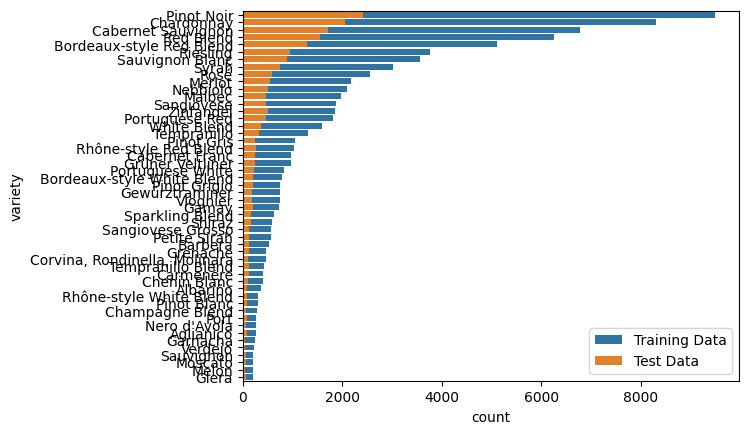

In [329]:
sns.barplot(X_train.variety.value_counts(), orient='h', label='Training Data', legend=True)
sns.barplot(X_test.variety.value_counts(), orient='h', label='Test Data', legend=True)

<Axes: xlabel='points', ylabel='count'>

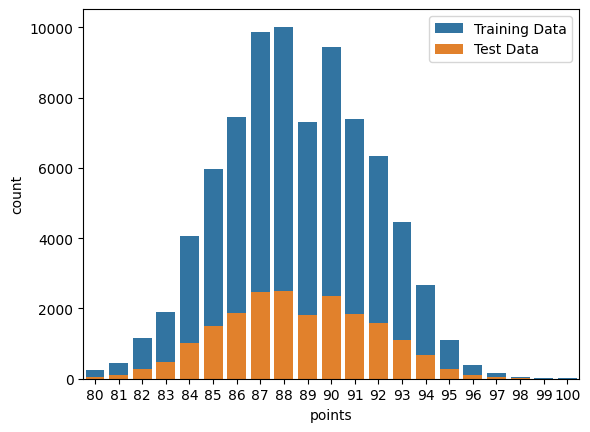

In [330]:
sns.barplot(y_train.value_counts(), label='Training Data', legend=True)
sns.barplot(y_test.value_counts(), label='Test Data', legend=True)

In [331]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression

def create_review_len_pipeline(estimator = LinearRegression()):
  return Pipeline([('pre',ColumnTransformer([('num', StandardScaler(), ['year']),
                                              ('len', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scale', StandardScaler())]),['review_len']),
                                              ('cat', OneHotEncoder(drop='first'), ['country', 'type'])
                                            ])),
                    ('lr',estimator)
                  ])

In [332]:
lr_pipe = create_review_len_pipeline()
lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('len',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['review_len']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'type'])])),
                ('lr', LinearRegression())])

In [333]:
lr_pipe.fit(X_train, y_train)

lr_pipe.score(X_train, y_train), lr_pipe.score(X_test, y_test)

(0.4253636939099391, 0.4310131201932177)

In [334]:
y_train = reviews.loc[y_train.index].rating
y_test = reviews.loc[y_test.index].rating


In [335]:
lr_pipe = lr_pipe = create_review_len_pipeline(LogisticRegression(max_iter=500))
lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('len',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['review_len']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'type'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [336]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train), lr_pipe.score(X_test, y_test)

(0.5163620539599652, 0.5186990252635767)

**Load TF-IDF**

In [337]:
cols = ['year', 'variety', 'country','location', 'type']

In [338]:
tfidf = pd.read_parquet('data/wine/wine_review-tfidf.parquet.gzip').drop(['year', 'variety'], axis=1)
print(tfidf.shape)
tfidf.loc[reviews.sample(5, random_state=42).index]

(100538, 940)


,accent,accessible,accompany,acid,acidic,acidity,acre,add,addition,additional,...,worth,wrap,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
12616,0.000000,0.0,0.0,0.237188,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49741,0.174744,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35244,0.000000,0.0,0.0,0.000000,0.0,0.118636,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52642,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83201,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [339]:
X = pd.concat([reviews[cols], tfidf], axis=1)
X

,year,variety,country,location,type,accent,accessible,accompany,acid,acidic,...,worth,wrap,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
0,2013,White Blend,Italy,Etna,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011,Portuguese Red,Portugal,Douro,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,Pinot Gris,US,Oregon,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013,Riesling,US,Michigan,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012,Pinot Noir,US,Oregon,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,2013,Riesling,Germany,Mosel,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.329377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129967,2004,Pinot Noir,US,Oregon,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129968,2013,Gewürztraminer,France,Alsace,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129969,2012,Pinot Gris,France,Alsace,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [340]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,reviews.points, test_size=0.2, random_state=42, stratify=reviews.points)
X_train.head()

,year,variety,country,location,type,accent,accessible,accompany,acid,acidic,...,worth,wrap,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
71166,2004,Sangiovese,Italy,Tuscany,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
80735,2009,Red Blend,US,Washington,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25052,2016,Sauvignon Blanc,France,Côtes de Gascogne,white,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
116451,2006,Bordeaux-style Red Blend,US,Colorado,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14434,2013,Pinot Noir,US,California,red,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.273009,0.0,0.0,0.0,0.0,0.0,0.0


In [341]:
def create_pipeline(estimator=LinearRegression()):
  return Pipeline([('pre',ColumnTransformer([('num', StandardScaler(), ['year']),
                                             ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), ['country', 'type', 'location', 'variety']),
                                            ], remainder='passthrough')),
                    ('lr', estimator)
                ])

In [342]:
tfidf_lr_pipe = create_pipeline()
tfidf_lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LinearRegression())])

In [343]:
tfidf_lr_pipe.fit(X_train, y_train)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LinearRegression())])

In [344]:
tfidf_lr_pipe.score(X_train, y_train), tfidf_lr_pipe.score(X_test, y_test)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.6746466867683162, 0.6610001865610315)

In [345]:
y_train = reviews.loc[y_train.index].rating
y_test = reviews.loc[y_test.index].rating


In [346]:
tfidf_lr_pipe = create_pipeline(LogisticRegression(max_iter=500))
tfidf_lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [347]:
tfidf_lr_pipe.fit(X_train, y_train)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [348]:
tfidf_lr_pipe.score(X_train, y_train), tfidf_lr_pipe.score(X_test, y_test)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.6494591570309586, 0.6233837278695047)

**Load Embeddings**

In [349]:
embeddings = pd.read_parquet('data/wine/mpnet_embeddings.parquet.gzip')
print(embeddings.shape)
embeddings.loc[reviews.sample(5, random_state=42).index]

(100538, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
12616,-0.014708,0.020043,-0.009147,0.013551,-0.110423,0.053819,-0.006565,0.013968,0.036468,-0.000290,...,-0.060500,0.060497,0.011859,0.028632,-0.013421,0.004273,-0.035511,0.016897,0.018761,-0.022760
49741,-0.021191,0.050148,-0.016899,0.025828,-0.044672,0.032061,-0.075622,0.000280,-0.018576,0.018633,...,-0.079470,0.023564,-0.000730,0.021145,-0.009717,-0.004303,-0.025926,0.005659,0.060257,-0.004926
35244,0.020322,0.046808,-0.018176,0.000103,-0.045383,0.045226,-0.052446,0.007467,0.075080,0.003979,...,-0.061666,-0.006262,0.029080,0.013944,-0.030095,0.042429,-0.041526,0.025593,0.015493,-0.053025
52642,-0.014583,0.083919,-0.029833,0.038764,-0.077833,-0.007320,-0.048311,-0.019116,0.040848,-0.023496,...,-0.096029,0.032004,-0.015027,0.024806,0.015687,0.017270,-0.063301,0.001191,0.024763,-0.021812
83201,0.048865,0.030238,-0.021778,-0.019585,-0.028988,0.041180,-0.080667,-0.033237,-0.060043,0.039234,...,-0.021986,0.032738,0.003107,0.005186,-0.014543,0.027938,-0.044192,0.046196,0.038627,0.015451


**Feature Engineering**

In [353]:
X = pd.concat([reviews.drop(['title', 'description', 'winery', 'points', 'rating', 'wine_style', 'classification', 'review_len', 'taster_name'], axis=1), embeddings], axis=1)
X.columns = X.columns.astype(str)
X

,year,variety,country,location,type,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
0,2013,White Blend,Italy,Etna,white,0.036825,0.040504,-0.049127,0.012060,-0.017809,...,-0.018225,-0.022451,-0.030674,0.030395,-0.036411,0.075180,-0.021670,0.017032,-0.024503,-0.021728
1,2011,Portuguese Red,Portugal,Douro,red,0.015400,0.076190,-0.017931,0.004965,-0.076234,...,-0.071278,0.033845,-0.002066,0.018129,-0.004691,0.028105,-0.042770,0.010317,0.063025,-0.026926
2,2013,Pinot Gris,US,Oregon,white,0.032447,0.012291,-0.034564,-0.020621,-0.048290,...,-0.126703,0.035472,0.029064,0.006745,-0.012355,0.030802,-0.012589,0.024286,0.023172,-0.017200
3,2013,Riesling,US,Michigan,white,0.076041,0.044183,-0.017158,-0.041186,-0.030582,...,-0.063876,-0.010313,0.004829,0.009389,-0.011263,0.035524,-0.014419,0.030267,-0.036529,-0.043187
4,2012,Pinot Noir,US,Oregon,red,0.011352,0.057223,-0.023293,0.022438,-0.078027,...,-0.058865,0.031108,0.006709,0.020604,-0.017218,0.023554,-0.039825,0.021364,0.025454,-0.022300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,2013,Riesling,Germany,Mosel,white,0.029442,-0.011380,-0.030752,0.014624,-0.033200,...,-0.064885,-0.002084,-0.001219,-0.041480,-0.022373,0.022929,-0.002631,0.009194,0.054336,-0.018222
129967,2004,Pinot Noir,US,Oregon,red,0.077417,0.038848,-0.021449,0.012509,-0.052197,...,-0.075107,0.047188,-0.035940,0.007552,0.004671,0.055764,-0.048221,0.019759,0.009636,-0.048461
129968,2013,Gewürztraminer,France,Alsace,white,-0.000970,0.050351,-0.021900,0.043341,-0.064250,...,-0.087418,0.025152,-0.035295,0.000705,-0.013046,0.043126,-0.058611,0.006239,0.049196,-0.018879
129969,2012,Pinot Gris,France,Alsace,white,-0.033838,0.001965,-0.014030,-0.001933,-0.054354,...,-0.086170,0.025275,-0.014610,0.014185,-0.002256,0.038448,-0.032181,0.017356,0.056261,-0.007649


In [354]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,reviews.points, test_size=0.2, random_state=42, stratify=reviews.points)
X_train.head()

,year,variety,country,location,type,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
71166,2004,Sangiovese,Italy,Tuscany,red,-0.015517,-0.028565,-0.026781,0.053700,-0.004936,...,-0.097514,-0.021607,0.013403,0.001048,-0.045254,0.019765,-0.018652,-0.001024,0.030262,0.033093
80735,2009,Red Blend,US,Washington,red,0.040970,-0.026239,-0.024915,-0.005610,-0.063496,...,-0.023481,0.030308,-0.017740,0.000611,0.005001,0.068376,-0.066297,0.019780,0.000633,-0.031555
25052,2016,Sauvignon Blanc,France,Côtes de Gascogne,white,0.068519,-0.005688,0.005931,0.014898,-0.036191,...,-0.052174,-0.017084,0.017666,0.028166,-0.028412,0.006846,-0.051830,0.015403,0.043663,-0.062009
116451,2006,Bordeaux-style Red Blend,US,Colorado,red,0.045580,0.001349,-0.016296,0.006883,-0.051746,...,-0.059892,0.024183,-0.005966,0.022143,-0.005425,0.006573,-0.025165,-0.003998,0.006135,-0.016485
14434,2013,Pinot Noir,US,California,red,0.013345,0.010441,-0.007903,0.004010,-0.054116,...,-0.026164,-0.007857,-0.013207,0.018279,0.022725,0.030198,-0.043576,0.027668,-0.036869,0.010956


In [355]:
embeddings_lr_pipe = create_pipeline()
embeddings_lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LinearRegression())])

In [356]:
embeddings_lr_pipe.fit(X_train, y_train)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LinearRegression())])

In [357]:
embeddings_lr_pipe.score(X_train, y_train), embeddings_lr_pipe.score(X_test, y_test)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.67246771027768, 0.6630565132274184)

In [358]:
embeddings_lr_pipe = create_pipeline(LogisticRegression(max_iter=500))
embeddings_lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [359]:
y_train = reviews.loc[y_train.index].rating
y_test = reviews.loc[y_test.index].rating

In [360]:
embeddings_lr_pipe.fit(X_train, y_train)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'type',
                                                   'location', 'variety'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [361]:
embeddings_lr_pipe.score(X_train, y_train), embeddings_lr_pipe.score(X_test, y_test)

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.6225537734676115, 0.6085140242689476)